In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from haversine import haversine, Unit
from sklearn.metrics.pairwise import haversine_distances
from tqdm import tqdm
from matplotlib.colors import ListedColormap, BoundaryNorm, LogNorm
import pandas as pd
from xhistogram.xarray import histogram
from sklearn.neighbors import KNeighborsRegressor, BallTree
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
from scipy.stats import linregress

def haversine_sklearn(lat1, lon1, lat_array, lon_array):


    X = np.array([lat1, lon1]).reshape(1, -1)
    Y = np.array([lat_array, lon_array]).T
    X = np.radians(X)
    Y = np.radians(Y)

    return haversine_distances(X, Y) * 6357
from matplotlib.colors import BoundaryNorm

colors = np.array([[0.10588235, 0.61960784, 0.46666667, 1.],
                [0.45882353, 0.43921569, 0.70196078, 1.],
                [0.4       , 0.4       , 0.4       , 1.],
                [0.90196078, 0.67058824, 0.00784314, 1.],
])

cmap = ListedColormap(colors)
#cmap = plt.get_cmap('Dark2')
bounds = [1, 2, 3, 4, 5]
norm = BoundaryNorm(bounds, cmap.N)
# Create a figure and axis with the specified size

SIC = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_unified_data/amsr_modis_sic.nc').sortby('time')
ds = xr.open_dataset('../../data/ar/HALO-AC3_HALO_VELOX_segmentation_statistics_with_sea_ice_edge_distance.nc')


fontsize = 8

plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.labelsize']  = fontsize
plt.rcParams['axes.titlesize']  = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['legend.title_fontsize'] = fontsize
plt.rcParams['figure.titlesize'] = fontsize
plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.axisbelow'] = True
sc_cmap = 'Dark2'

cmap = ListedColormap(colors)

ERROR 1: PROJ: proj_create_from_database: Open of /home/jomueller/micromamba/envs/mamba_josh/share/proj failed


In [2]:
np.unique(ds['segment_date'])

array(['2022-03-28', '2022-03-29', '2022-03-30', '2022-04-01',
       '2022-04-04'], dtype='<U10')

total area 24256.238 km²


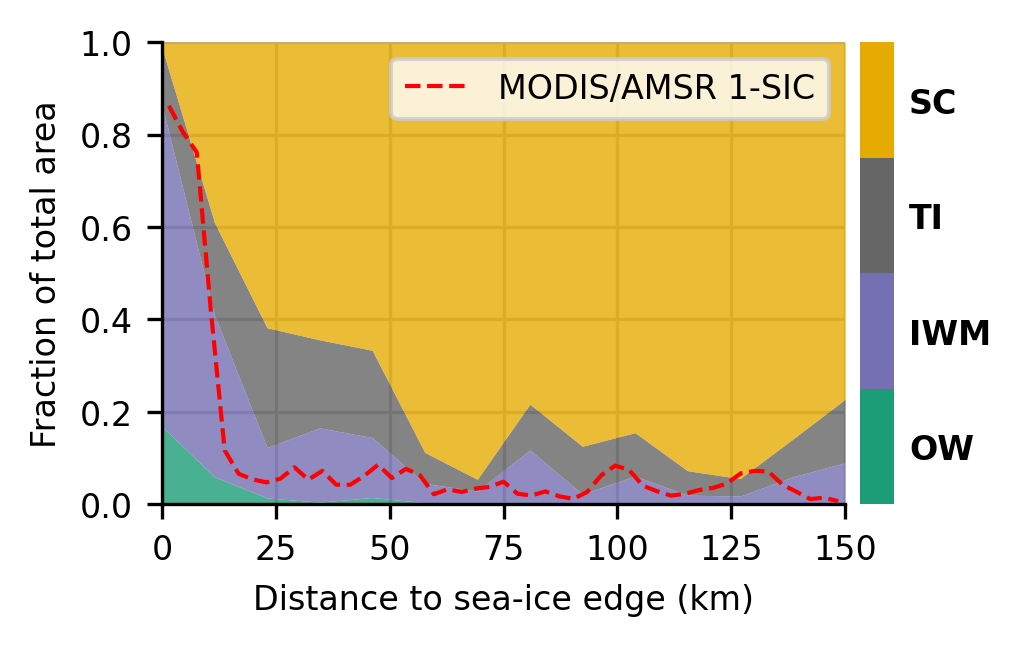

In [5]:
total_area = ds.segment_size.sum()

print('total area', total_area.values/1e4 ,'km²')

spacing = 15

dsgp_edge_dist = ds.groupby_bins('segment_edge_dist', np.linspace(0, 150, spacing))
dsgp_label = ds.groupby('segment_label').sum()

df = pd.DataFrame(
    columns=['Open Water', 'Snow Covered Ice', 'Thin Ice', 'Ice Water Mix'],
    data = np.zeros((spacing-1, 4)),

    #index=np.linspace(0, 200, 20)
)



df = df[['Open Water', 'Ice Water Mix', 'Thin Ice', 'Snow Covered Ice']]

#dsgp_edge_dist.segment_size.where(dsgp_edge_dist.segment_label == 2)

for i, group in enumerate(dsgp_edge_dist):
    open_water_area = group[1].segment_size.where(group[1].segment_label == 1).sum().values
    snow_covered_ice_area = group[1].segment_size.where(group[1].segment_label == 3).sum().values
    thin_ice_area = group[1].segment_size.where(group[1].segment_label == 4).sum().values
    ice_water_mix_area = group[1].segment_size.where(group[1].segment_label == 2).sum().values

    total_area = open_water_area + snow_covered_ice_area + thin_ice_area + ice_water_mix_area

    df.loc[i, 'Open Water'] = open_water_area / total_area
    df.loc[i, 'Snow Covered Ice'] = snow_covered_ice_area / total_area
    df.loc[i, 'Thin Ice'] = thin_ice_area / total_area
    df.loc[i, 'Ice Water Mix'] = ice_water_mix_area / total_area

df.set_index(np.linspace(0, 150, spacing-1), inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(3.15, 2))

im = df.plot.area(stacked=True, cmap=cmap, ax=ax, alpha=.8, legend=False, linewidth=0, label='')


#ax.legend(title='Surface type', loc='upper right', fontsize=6)
### add a colorbar instead of a legend

### make a colormap from listedcolors 

# from matplotlib.colors import ListedColormap

# cmap = ListedColormap(colors)


im = ax.contourf(np.array([[1, 2, 3, 4], [1, 2, 0, 4]]), cmap=cmap, alpha=1, levels=[0.5, 1.5, 2.5, 3.5, 4.5])
im.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=[1, 2, 3, 4])
cbar.set_ticklabels(['OW', 'IWM', 'TI', 'SC'], fontweight='bold')
cbar.ax.yaxis.set_tick_params(width=0, length=0)
cbar.ax.yaxis.set_ticks_position('none')
cbar.ax.set_frame_on(False)
### shift the colorbar to the right

ax.axes.grid(True)
imi = (1 - ds.groupby_bins('segment_edge_dist', np.linspace(0, 150, 50)).mean().segment_sic / 100).plot(ax=ax, color='r', linestyle='--', linewidth=1, zorder=100)

label = ['MODIS/AMSR 1-SIC']
handles = imi

ax.legend(handles, label, loc='upper right', fontsize=8)

ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Distance to sea-ice edge (km)')
# ax.text(-0.1, -0.35, '    Ice edge\n   (SIC = 10%)\n  ← Open Ocean', transform=ax.transAxes, fontweight='bold', fontsize=8)
# #ax.text(-0.27, -0.2, '← Open Ocean\n', transform=ax.transAxes, fontweight='bold', fontsize=6)
# #ax.text(0.8, -0.2, '→\n', transform=ax.transAxes, fontweight='bold', fontsize=6)
# ax.text(.9, -0.35 , 'Internal  →\nice zone \n', transform=ax.transAxes, fontweight='bold', fontsize=8)
ax.set_ylabel('Fraction of total area')
ax.axes.grid(True)
ax.set_xlim([0, 150])
ax.set_ylim([0, 1])

plt.savefig('../../plots/publish/figure10', bbox_inches='tight', dpi=300)
